# Classifying Shapes

In this notebook I build a convolutional neural network using PyTorch and train it to classify images of circles, squares and triangles. Whilst writing this I am learning to build machine learning models on Microsoft Azure and this notebook is based on examples from that course. The purpose for my benefit is to get more familiar with using PyTorch.

In [1]:
# Import necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.9.0+cpu


## Data Exploration

With the necessary packages imported we can explore the data by examining the classes and plotting some examples.

3 classes:
['circle', 'square', 'triangle']


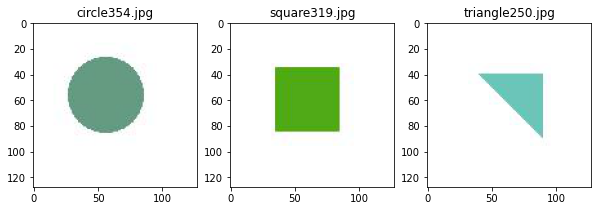

In [7]:
#Use the names of the directories as the class names
data_path = 'data/shapes'
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

#Plot an example from each class
fig = plt.figure(figsize=(10, 10))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    image_file_name = os.listdir(os.path.join(data_path,sub_dir))[0]
    image_path = os.path.join(data_path, sub_dir, image_file_name)
    img = mpimg.imread(image_path)
    a=fig.add_subplot(1, len(classes),i)
    imgplot = plt.imshow(img)
    a.set_title(image_file_name)
plt.show()

## Preparing the Data

Now we will define a function that makes use of PyTorch's loading functions. The images need to be transformed into tensors to be used by PyTorch. We can also use this as an opportunity for feature scaling, and will scale the pixel values to have a mean of 0.5 and standard deviation also of 0.5.

In [8]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        #transform the images to tensors
        transforms.ToTensor(),
        #Normalise the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    #Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    #Split into training (70%) and test (30%) datasets
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    #define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    #now the same for the test data
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


#Call the loading functions
train_loader, test_loader = load_dataset(data_path)
print('Data loading functions ready')

Data loading functions ready


## Define the CNN

Now we will define the neural network model as a class derived from PyTorch's nn.Module class. In the CNN model, the \textbf{kernal_size} parameter determines the size of the convolutional kernel or filter, \textbf{stride} determines the step size or the number of pixels the kernel moves at each step during the convolution operation and \textbf{padding} is used to preserve the spatial dimensions of the input after convolution.

In [12]:
class Neural_Net(nn.Module):
    #construct the network
    def __init__(self, num_classes=3):
        #initialize the attributes of the parent class
        super(Neural_Net, self).__init__()
        
        #As the images are RGB, we need 3 input channels. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        #We'll apply max pooling to pick out the most prominent features, using a kernel size of 2.
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        #The next layer will take 12 input channels and generate 12 outputs, using a kernal size of 3.
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        #We'll add a third layer that takes 12 inputs and this time generate 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        #The drop layer deletes 20% of the features which helps prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # So our feature tensors are now 32 x 32, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to the probability for each class
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool(self.conv2(x)))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv3(x)))
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return log_softmax tensor 
        return F.log_softmax(x, dim=1)

## Train the model

Now the CNN is defined we can train it on the shape data. We'll use the test sample to track the loss with each epoch. The machine I am currently using does not have a GPU so will take time to train, but a check will be included so that it can be run on a GPU if present for future runs.

In [13]:
def train(model, device, train_loader, optimizer, epoch):
    #Set the model to training mode
    model.train()
    #Initiate the training loss
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda 
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Neural_Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

epochs = 10
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set [0/840 (0%)] Loss: 1.093195


/home/phil/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training set [500/840 (59%)] Loss: 0.968049
Training set: Average loss: 0.972940
Validation set: Average loss: 0.586700, Accuracy: 266/360 (74%)

Epoch: 2
Training set [0/840 (0%)] Loss: 0.585752
Training set [500/840 (59%)] Loss: 0.411508
Training set: Average loss: 0.426604
Validation set: Average loss: 0.316492, Accuracy: 290/360 (81%)

Epoch: 3
Training set [0/840 (0%)] Loss: 0.256854
Training set [500/840 (59%)] Loss: 0.337093
Training set: Average loss: 0.244400
Validation set: Average loss: 0.182144, Accuracy: 334/360 (93%)

Epoch: 4
Training set [0/840 (0%)] Loss: 0.159111
Training set [500/840 (59%)] Loss: 0.120119
Training set: Average loss: 0.147431
Validation set: Average loss: 0.066065, Accuracy: 356/360 (99%)

Epoch: 5
Training set [0/840 (0%)] Loss: 0.093368
Training set [500/840 (59%)] Loss: 0.060568
Training set: Average loss: 0.055997
Validation set: Average loss: 0.029302, Accuracy: 359/360 (100%)

Epoch: 6
Training set [0/840 (0%)] Loss: 0.024846
Training set [500/8

## View the loss history

Plot the training and test data verify the loss has decreased over each epoch and to detect the presence of any overfitting.

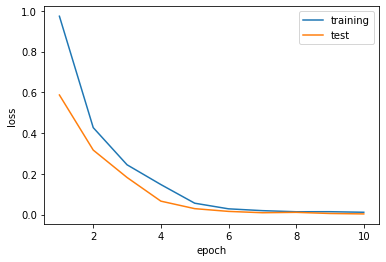

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'test'], loc='upper right')
plt.show()

## Evaluate model performance

It looks like the model has converged nicely for both the training and test data! Let's explore the performance metrics in more detail. We will create a confusion matrix to see how well the model has predicted each class.

Getting predictions from test set...


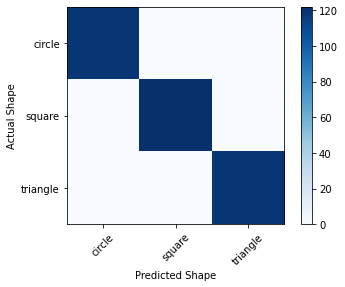

In [16]:
#we'll use cciKit-learn to generate the confusion matrix
from sklearn.metrics import confusion_matrix

#set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with scikit-learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

We saw that the model had an accuracy of 100% so the result of the confusion matrix is not surprising!

## Save the Trained model

Now we can save the model for later use.

In [17]:
# Save the model weights
model_file = 'models/shape_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as models/shape_classifier.pt


## Use the trained model

Finally, we can use the trained model to predict classes for new images (which we can generate using Python!).

triangle


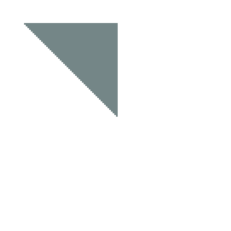

In [24]:
#Import these packages again so we don't have to scroll up to the top if we forget to run that cell.
import matplotlib.pyplot as plt
import os
from random import randint
%matplotlib inline


#predictor function
def predict_image(classifier, image):
    import numpy
    
    #set the model to evaluation mode
    classifier.eval()
    
    #we need to apply the same transformations that we did to the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
shape = classnames[randint(0, len(classnames)-1)]
img = create_image ((128,128), shape)

# Display the image
plt.axis('off')
plt.imshow(img)

# Create a new model class and load the saved weights
model = Neural_Net()
model.load_state_dict(torch.load(model_file))

# Call the predction function
index = predict_image(model, img)
print(classes[index])